NAME: __TODO: FULLNAME__

# Machine Learning Practice - Asynchronous
## Homework 05: Regularization 

### Data set
The BMI (Brain Machine Interface) data are stored in a single pickle file; within this file, there is one dictionary that contains all of the data.  The keys are: 'MI', 
'theta', 'dtheta', 'ddtheta', 'torque', and 'time'.  Each of these objects are python lists with 20 
numpy matrices; each matrix contains an independent fold of data, with rows representing 
different samples and columns representing different features.  The samples are organized 
contiguously (one sample every 50ms), but there are gaps in the data.
* _MI_ contains the data for 48 neurons.  Each row encodes the number of action potentials for 
each neuron at each of 20 different time bins (so, 48 x 20 = 960 columns).  
* _theta_ contains the angular position of the shoulder (in column 0) and the elbow 
(in column 1) for each sample.  
* _dtheta_ contains the angular velocity of the shoulder (in column 0) and the elbow 
(in column 1) for each sample.  
* _ddtheta_ contains the angular acceleration of the shoulder (in column 0) and the elbow 
(in column 1) for each sample. 
* _torque_ contains the torque of the shoulder (in column 0) and the elbow (in column 1) for each sample.  
* _time_ contains the actual time stamp of each sample.

A fold is a subset of the available data.  Each fold contains independent time points.

This assignment uses code examples and concepts from the lectures on regression 


### Task
For this assignment you will be exploring **regularization.** Regularization
is a powerful tool in machine learning to impose rational constraints on 
models during the training process to mitigate overfitting to the training 
set and improve model generalization. By including one or more terms within
the cost (error) function to penalize the weights, the learning algorithm will try 
to fit the data while avoiding certain values for the weights that might 
overfit the data.


### Objectives
* Use and understand regularization in regression
* Learn to select hyper-parameters to tune model behavior


### Instructions
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results
* Hand-In Procedure
  + Make sure that your notebook has been saved
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradscope Notebook HW05 dropbox


    
### Notes
* Be sure to adequately label all the plots you generate.
* Make sure that you save your notebook before copying it.


### General References
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [JobLib](https://joblib.readthedocs.io/en/latest/)


In [1]:
# PROVIDED
import pickle as pkl
import pandas as pd
import numpy as np
import os, re, fnmatch, time
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import make_scorer

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 12

%matplotlib inline

# LOAD DATA

In [3]:
""" PROVIDED: Execute cell
Load the BMI data from all the folds
"""
fname = '/mlp/datasets/bmi/bmi_dataset.pkl'

with open(fname, 'rb') as f:
    bmi = pkl.load(f)
    theta_folds = bmi['theta']
    dtheta_folds = bmi['dtheta']
    ddtheta_folds = bmi['ddtheta']
    torque_folds = bmi['torque']
    time_folds = bmi['time']
    MI_folds = bmi['MI'] 

print("Number of folds:", len(MI_folds))

Number of folds: 20


# Helper Functions

In [16]:
""" TODO
Evaluate the training performance of an already trained model
"""
def mse_rmse(trues, preds):
    '''
    Compute MSE and rMSE for each column separately.
    '''
    mse = np.sum(np.square(trues - preds), axis=0) / trues.shape[0]
    rmse = np.sqrt(mse)
    return mse, rmse, rmse * 180 / np.pi

def predict_score_eval(model, X, y):
    # TODO: copy your implementation from the previous assignment
    #  Make sure to use model.score to compute FVAF
    '''
    Compute the model predictions and cooresponding scores.
    PARAMS:
        model: the trained model used to make predicitons
        X: feature data (MxN)
        y: cooresponding output (Mxk)
    RETURNS:
        mse: mean squared error for each column (k vector)
        rmse_rads: rMSE in radians (k vector)
        rmse_deg: rMSE in degrees (k vector)
        fvaf: fraction of variance accounted for metric (k vector)
        preds: predictions made by the model (M x k matrix)
    '''
    
    # TODO
    preds = model.predict(X)
    
    mse, rmse_rads, rmse_deg = mse_rmse(y, preds)
    
    variance_trues = np.var(y, axis=0)
    variance_residuals = np.var(y - preds, axis=0)
    fvaf = (1 - (variance_residuals / variance_trues)) * 100
    
    
    return mse, rmse_rads, rmse_deg, fvaf, preds




In [17]:
'''
PROVIDED: Execute Cell
'''
def extract_data_set(data, folds):
    '''
    For the data provided, extract only the specified folds and concatenate them together
    
    :param data: Python list of all folds of any number of types (e.g., 20 folds 
        of ddtheta and torque)
    :param folds: Python list of fold indices to extract
    :return: Tuple of the specific types, containing only the specified folds
    '''
    # For each field in data, extract only the specified folds
    output = [np.concatenate([d[f] for f in folds]) for d in data]
    
    # Convert the list to a tuple
    return tuple(output)

In [7]:
"""
TODO

Construct training, validation and test sets

Training set: used for selecting model parameters
Validation set: used for selecting model hyper-parameters
Test set: used sparingly to evaluate the final model

We are building models to predict joint position
"""
# Extract fold indices for the training, validation and testing sets
trainset_fold_inds = [9] 
validationset_fold_inds = [0, 1] 
testset_fold_inds = [18,19] 

# Data to predict
predict_folds = theta_folds
# Shoulder
predict_index = 0

# Combine the folds into singular numpy arrays

# Training set
Xtrain, ytrain, timetrain = extract_data_set([MI_folds, predict_folds, time_folds],
                          trainset_fold_inds)
ytrain = np.reshape(ytrain[:,predict_index], newshape=(-1,))

# Validation set
Xval, yval, timeval = extract_data_set([MI_folds, predict_folds, time_folds], validationset_fold_inds) 
yval = np.reshape(yval[:,predict_index], newshape=(-1,))


# Testing set
Xtest, ytest, timetest = extract_data_set([MI_folds, predict_folds, time_folds], testset_fold_inds)
ytest = np.reshape(ytest[:,predict_index], newshape=(-1,))

Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((1257, 960), (1257,), (2297, 960), (2297,), (2678, 960), (2678,))

In [18]:
# PROVIDED: Execute Cell

Xtrain.shape, ytrain.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((1257, 960), (1257,), (2297, 960), (2297,), (2678, 960), (2678,))

## Linear Model

In [19]:
""" TODO
Construct and train a linear model using the training set.
Display the Training set rmse (degrees) and fvaf
"""
# model_lnr = # TODO
# TODO
model_lnr = LinearRegression()
model_lnr.fit(Xtrain , ytrain)
# Show the performance of the model with respect to the training set
#  Print RMSE in degrees and FVAF
# TODO
mse, rmse, rmse_deg, fvaf, preds = predict_score_eval(model_lnr, Xtrain, ytrain)
print(fvaf, rmse_deg)

94.80336614338887 3.2606820421442775


In [20]:
# TODO
# Show model performance with respect to the validation data set
#  Print RMSE in degrees and FVAF
mse, rmse, rmse_deg, fvaf, pred = predict_score_eval(model_lnr, Xval, yval)
print(fvaf, rmse_deg)

-12.057365644699324 14.851864414711873


## Regularized Regression

In [21]:
# PROVIDED: execute cell

# Create a Lasso model
model_regularized = Lasso()

# A set of alpha parameter values to try 
#  These are factors of 10 from 10^-6 to 10^0 spaced exponentially 

alphas = np.logspace(-6, 0, base=10, num=30, endpoint=True)
alphas

array([1.00000000e-06, 1.61026203e-06, 2.59294380e-06, 4.17531894e-06,
       6.72335754e-06, 1.08263673e-05, 1.74332882e-05, 2.80721620e-05,
       4.52035366e-05, 7.27895384e-05, 1.17210230e-04, 1.88739182e-04,
       3.03919538e-04, 4.89390092e-04, 7.88046282e-04, 1.26896100e-03,
       2.04335972e-03, 3.29034456e-03, 5.29831691e-03, 8.53167852e-03,
       1.37382380e-02, 2.21221629e-02, 3.56224789e-02, 5.73615251e-02,
       9.23670857e-02, 1.48735211e-01, 2.39502662e-01, 3.85662042e-01,
       6.21016942e-01, 1.00000000e+00])

In [23]:
# TODO

def hyperparameter_loop(model, alphas, Xtrain, ytrain, Xval, yval):
    '''
    Loop over all possible alphas:
    - Set the model.alpha parameter to the specific alpha
    - Fit model to Xtrain/ytrain
    - Compute rmse (DEG) and FVAF for Xtrain/ytrain and Xval/yval & record these in 
            numpy arrays 
     Return the fvaf amd rmse_degree for both the training and validation sets
    
    :param model: ML model to fit
    :param alphas: List of alpha hyper-parameter values to try
    :param Xtrain: training set inputs
    :param ytrain: training set desired output
    :param Xval: validation set inputs
    :param yval: validation set desired output
    :return: rmse/fvaf for the training set and validation set, as well as the zero count
    '''
    rmse_train = np.zeros((len(alphas),))
    rmse_valid = np.zeros((len(alphas),))
    fvaf_train = np.zeros((len(alphas),))
    fvaf_valid = np.zeros((len(alphas),))
    zero_count = np.zeros((len(alphas),))
    
    # Loop over all possible alphas
    for i, a in enumerate(alphas):
        # Set model.alpha
        model.alpha =  a
        
        # Fit the model to the training set
        model.fit(Xtrain, ytrain)
        
        # Record rmse/fvaf for both training and validation sets
        _, _, rmse_deg, fvaf, _ = predict_score_eval(model, Xtrain, ytrain)
        rmse_train[i] = rmse_deg
        fvaf_train[i] = fvaf
        
        _, _, rmse_deg, fvaf, _ = predict_score_eval(model, Xval, yval)
        rmse_valid[i] = rmse_deg
        fvaf_valid[i] = fvaf
        
        # Count and the number of model parameters that are exactly zero
        zero_count[i] = np.sum(model.coef_ == 0) 
        
        
    # Return training and validation performance arrays
    return rmse_train, fvaf_train, rmse_valid, fvaf_valid, zero_count

In [24]:
# TODO
# Call hyperparameter_loop with the regularized model
rmse_train, fvaf_train, rmse_valid, fvaf_valid, zero_count = hyperparameter_loop(
    model_regularized, alphas, Xtrain, ytrain, Xval, yval)

rmse_train, fvaf_train, rmse_valid, fvaf_valid, zero_count 


(array([ 3.26071819,  3.2607752 ,  3.26092107,  3.26129382,  3.26221363,
         3.26447986,  3.26990957,  3.28247564,  3.30903814,  3.36464992,
         3.46641163,  3.62917991,  3.85085614,  4.14077414,  4.56986348,
         5.0261786 ,  5.5236787 ,  6.15845   ,  6.90042106,  7.73759619,
         8.69669633, 10.10605172, 12.17299028, 13.5525935 , 14.30366705,
        14.30366705, 14.30366705, 14.30366705, 14.30366705, 14.30366705]),
 array([94.80325093, 94.80306921, 94.80260423, 94.80141596, 94.79848315,
        94.79125372, 94.77391222, 94.73366796, 94.64809051, 94.46669023,
        94.1269259 , 93.56242633, 92.75197298, 91.61953147, 89.79268149,
        87.65244273, 85.0871025 , 81.46263274, 76.7267841 , 70.73710172,
        63.03303245, 50.08072742, 27.57312186, 10.22611094,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([14.80012246, 14.76883689, 14.71901899, 14.64023766, 14.52046845,
        14.33848968, 14.07562984, 13.69927439, 

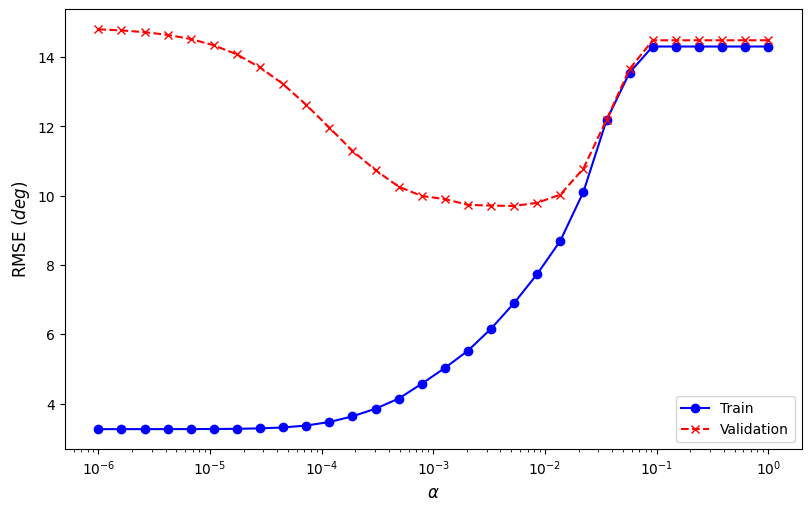

In [25]:
# TODO
# Plot training and validation rmse as a function of alpha
#  Set the xscale to 'log'

plt.figure()
plt.plot(alphas, rmse_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(alphas, rmse_valid, marker='x', linestyle='--', color='red', label='Validation')

# Setting the x-scale to 'log'
plt.xscale('log')

plt.xlabel(r'$\alpha$')
plt.ylabel(r'RMSE ($deg$)')
plt.legend(['Train', 'Validation'])

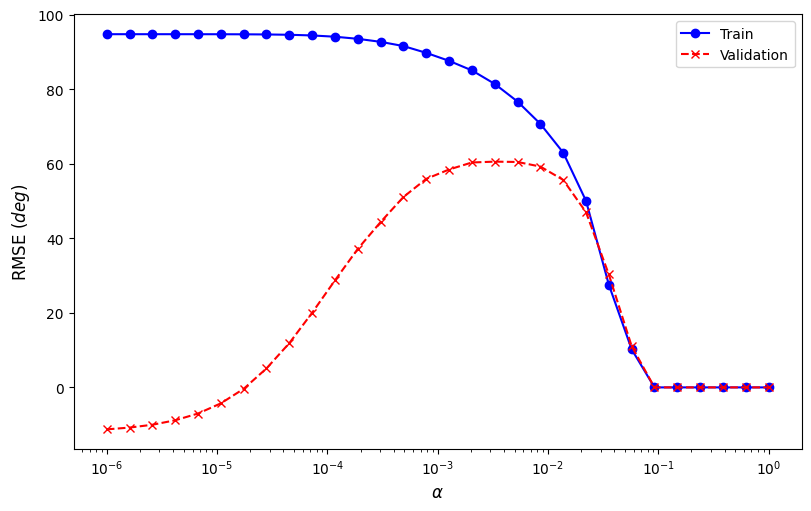

In [26]:
# TODO
# Plot training and validation FVAF as a function of alpha
#  Set the xscale to 'log'

plt.figure()
plt.plot(alphas, fvaf_train, marker='o', linestyle='-', color='blue', label='Train')
plt.plot(alphas, fvaf_valid, marker='x', linestyle='--', color='red', label='Validation')
# Setting the x-scale to 'log'
plt.xscale('log')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'RMSE ($deg$)')
plt.legend(['Train', 'Validation'])

Text(0.5, 1.0, 'Number of Zero Parameters as a function of alpha')

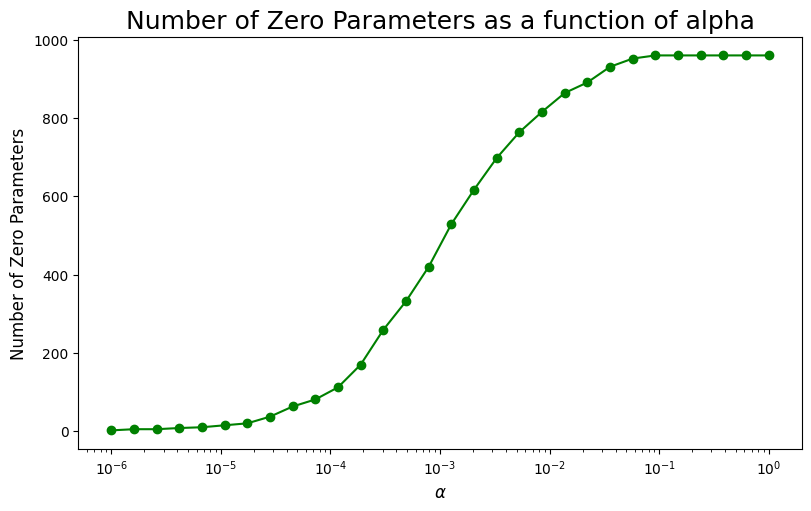

In [28]:
# TODO
# Plot the number of parameters that are exactly zero as a function of alpha
#  Set the xscale to 'log'

plt.figure()
plt.plot(alphas, zero_count, marker='o', linestyle='-', color='green')
plt.xscale('log')

# Setting labels and title
plt.xlabel(r'$\alpha$')
plt.ylabel('Number of Zero Parameters')
plt.title('Number of Zero Parameters as a function of alpha')


In [29]:
# TODO
# Identify and print the index in rmse_valid that is best
idx_rmse = np.argmin(rmse_valid)
idx_rmse

18

In [30]:
# TODO
# Show the alpha that corresponds to this best model
# TODO
best_alpha = alphas[idx_rmse]
best_alpha

0.005298316906283708

In [31]:
# TODO
# Identify and print the index in fvaf_valid that is best
idx_fvaf = np.argmax(fvaf_valid)
idx_fvaf

17

In [32]:
# TODO
# Show the alpha that corresponds to this best model
# TODO
best_alpha_fvaf = alphas[idx_fvaf]
best_alpha_fvaf

0.0032903445623126675

In [33]:
# TODO
# Set the regularized model alpha to the best value with respect to FVAF
#  and fit the model to the training data

# TODO
model_regularized.alpha = best_alpha_fvaf
model_regularized.fit(Xtrain, ytrain)

Lasso(alpha=0.0032903445623126675)

In [34]:
# TODO
# Compute the predictions for the training data

predtrain = model_regularized.predict(Xtrain)
predtrain

array([0.3818905 , 0.36755023, 0.36456714, ..., 0.00084622, 0.11359793,
       0.29416515])

In [35]:
# TODO
# Compute the predictions for the test data
predtest = model_regularized.predict(Xtest)

# Report the rmse and fvaf for the test data
# TODO
_, _, rmse_deg, fvaf, _ = predict_score_eval(model_regularized, Xtest, ytest)
print(rmse_deg, fvaf)

8.977017827660383 55.14852329234653


In [36]:
# TODO
# You have already fit the LinearRegression model to the training data
#  Use it to predict arm movement for the test data
preds_lnr = model_lnr.predict(Xtest)
preds_lnr

array([ 0.62067511,  0.41629936,  0.36489128, ..., -0.01505602,
        0.03874439,  0.10735458])

In [37]:
# TODO
# Report the LinearRegression rmse and fvaf for the test data
_, _, rmse_deg, fvaf, _ = predict_score_eval(model_lnr, Xtest, ytest)

print(rmse_deg, fvaf)

15.607925226383125 -43.49636253948359


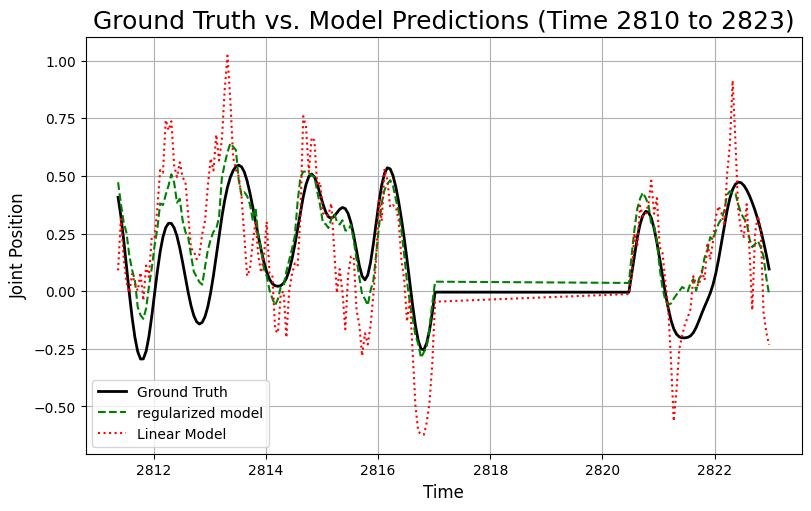

In [41]:
# TODO
# Plot: ground truth, regularized model predictions and the Linear model predictions for 
#  time period 2810 to 2823

start_time =2810
end_time =2823
time_indices = np.where((timetest >= start_time) & (timetest <= end_time))[0]

#Extract ground truth and Predictions for the specified time indices
ground_truth = ytest[time_indices]
preds_regularized_subset = predtest [time_indices]
preds_lnr_subset =preds_lnr[time_indices]
time_subset = timetest[time_indices]

#Plotting 
plt.figure
plt.plot(time_subset ,ground_truth ,label = 'Ground Truth' , color='black', linewidth = 2)
plt.plot(time_subset , preds_regularized_subset , label='regularized model', color = 'green', linestyle='--')
plt.plot(time_subset , preds_lnr_subset , label = 'Linear Model', color = 'red', linestyle=':')


plt.xlabel('Time')
plt.ylabel('Joint Position')
plt.title('Ground Truth vs. Model Predictions (Time 2810 to 2823)')
plt.legend()
plt.grid(True)


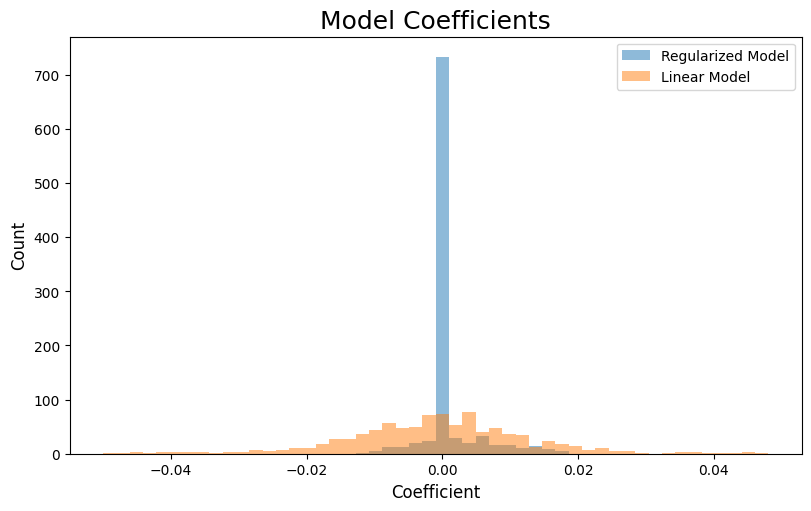

In [42]:
""" PROVIDED: execute cell
Generate a plot that contains two overlapping histograms:
- Coefficients discovered by LinearRegression
- Coefficients discovered by the best regularized model

"""
nbins = 51
start = -0.05
end = 0.05
incr = (end - start) / nbins
bins = np.arange(start, end, incr)

# Use bins=bins.  This will use the exact same bins for
#   both histograms
plt.figure()
plt.hist(model_regularized.coef_, bins=bins, label="Regularized Model", alpha=.5)
plt.hist(model_lnr.coef_, bins=bins, label="Linear Model", alpha=.5)
plt.xlabel('Coefficient')
plt.ylabel('Count')
plt.title("Model Coefficients")
plt.legend()


## Reflection
Respond to each of the following questions with short answers.


### 1. For the simple LinearRegression model, what is the difference in performance between the training and validation sets?  Explain this difference

### The Linear Regreesion model showed better performance on the training set compared to the validation set ,This is Evident from the Lower RMSE and higher FVAF for the training set.The disparity in perofrmance CAN BE ATTRIBUTED TO OVERFITTING .The Linear Regression model tries to fit the training data as closely as possible ,potentially capturing noise or specific characteristics that dont generalize well to unseen data , resulting in poorer performance on the validation set.

### 2. For the RMSE vs alpha curves, describe the difference between the training and validation data sets.  Explain this difference.

### For the traing set , as Alpha increases ,The RMSE also Increases ,This indicates that as we impose stronger regularization , the model fits the the training data less closely , For the validation set , initially the RMSE decreases as aplha increases , suggesting a reduction in overfitting.However after a certain point , the RMSE Starts to increase indidicating underfitting , The discrepancy between training and validation curves is due to the trade-off between model complexity and generalization.


### 3.  Referring to the figure showing the Zero Coefficient Count as a function of alpha, describe and then explain the shape of the curve. 

### The curve starts at a low count and increases as alpha rises , This indicates that as we increase the regularization strength , mor co-efficients in the lasso model are shrunk to zero , This behavior is inherent to lasso regression,where stronger regularization promotes sparsity by setting a larger number of co-efficients to zero.


### 4. How does the performance of the best Regularized Model compare to that of the LinearRegression model with respect to the test data set?

### The best Refgularized Model , selected based on FVAF performed better on the test set compared to the linear regression model . The regularization model . The regularization introduced in the Lasso model likely helped prevent overfitting , resulting in better generalization to the test data compared to the non-regularized linear regression model.

### 5. Explain the difference in the model coefficient histograms between the regularized model and the LinearRegression model.

### The Histogram for the regularized model shows a higher concentration of co-efficents around zero compared to the Linear RTegresion model .Many coefficients in the regularized model are exactly or nearly zero , indicating the sparsity promoting effect of the L1 regularization in Lasso.